In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
pd.set_option('display.max_colwidth', None)
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.integrate import quad
import scipy.integrate as integrate
import scipy.special as special
import math
import random
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
from pylab import plot, show, grid, xlabel, ylabel
from collections import defaultdict
import copy

In [2]:
import pickle

def save_in_pickle(save_object, save_file):
    with open(save_file, "wb") as pickle_out:
        pickle.dump(save_object, pickle_out)

def load_from_pickle(pickle_file):
    with open(pickle_file, "rb") as pickle_in:
        return pickle.load(pickle_in)

In [3]:
# The statespace
states = ["Mild","Moderate","Harsh"]
paths = load_from_pickle("paths.pkl")
X_t = load_from_pickle("X_t.pkl")

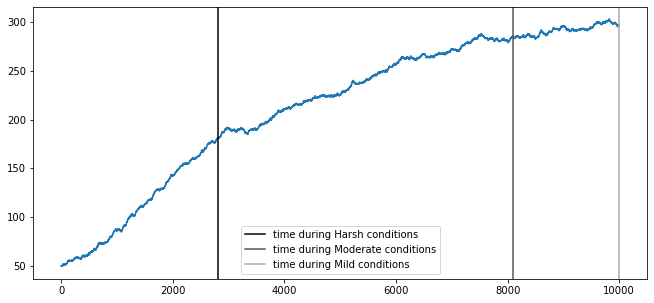

In [4]:
plot(X_t[0])
for env, time in paths[0]:
    plt.axvline(time, 0, 1, label=f'time during {states[env]} conditions',color = str(1-(env+1)/3))
plt.legend()

plt.show()

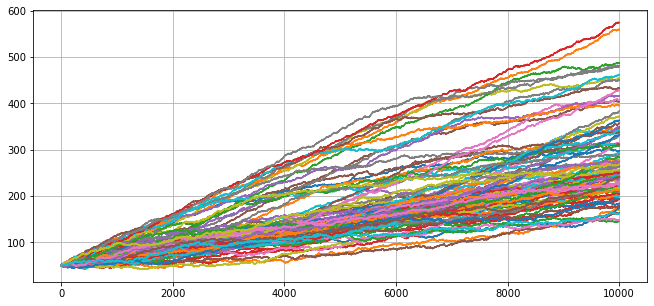

In [5]:
for k in range(100):
    plot(X_t[k])
grid(True)

In [6]:
clipped_paths = []
clipped_X_t = []
for i in range(100):
    limit = np.argmax(X_t[i]>150)
    new_path = []
    for env,time in paths[i]:
        if time < limit:
            new_path.append((env,time))
        else:
            new_path.append((env,limit))
            break
    clipped_X_t.append(X_t[i][:limit+1])
    clipped_paths.append(new_path)

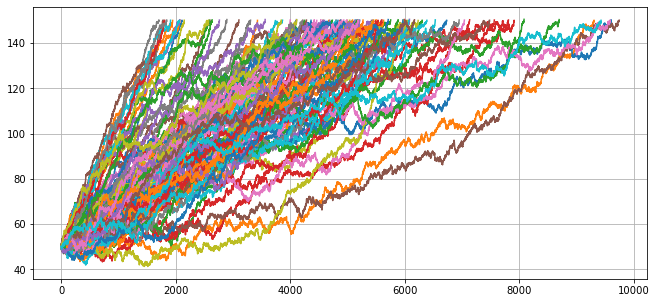

In [7]:
for k in range(100):
    plot(clipped_X_t[k])
grid(True)

In [8]:
save_in_pickle(clipped_paths,'clipped_paths.pkl')
save_in_pickle(clipped_X_t,'clipped_X_t.pkl')

## Estimating parameters for degradation model

In [9]:
phi = np.mean([X[0] for X in clipped_X_t])

In [10]:
X_t_env = [[],[],[]]
for i in range(100):
    start = 0
    for env,end in clipped_paths[i]:
        diff = clipped_X_t[i][start] - phi
        X_t_env[env].append(np.array(clipped_X_t[i][start:end+1]) - diff)
        start = end+1

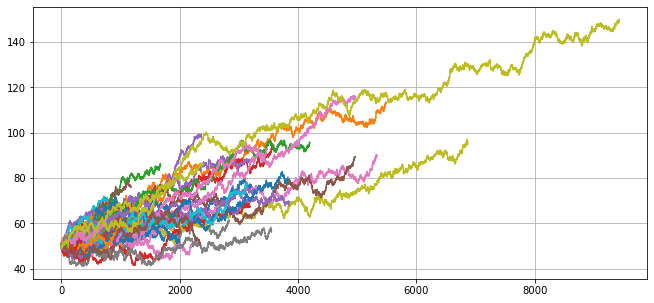

In [11]:
for k in range(len(X_t_env[0])):
    plot(X_t_env[0][k])
grid(True)

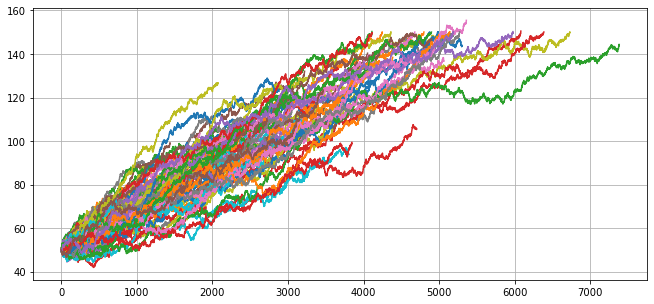

In [12]:
for k in range(len(X_t_env[1])):
    plot(X_t_env[1][k])
grid(True)

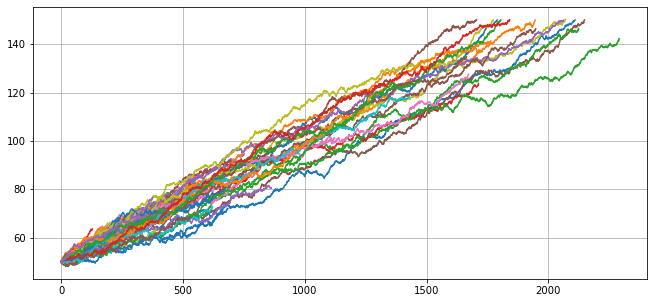

In [13]:
for k in range(len(X_t_env[2])):
    plot(X_t_env[2][k])
grid(True)

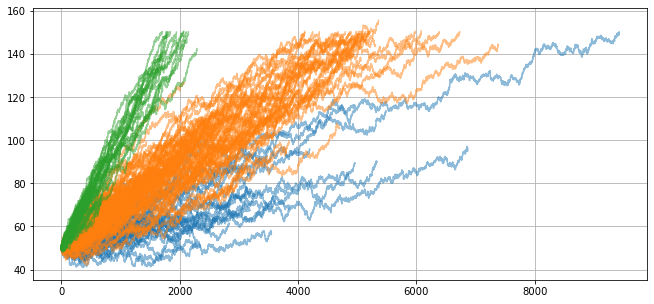

In [14]:
colors = ['tab:blue','tab:orange','tab:green']
for i in range(3):
    for k in range(len(X_t_env[i])):
        fig = plot(X_t_env[i][k],color=colors[i], alpha=0.5)
    grid(True)


### Estimating rate of increase $\mu$

In [15]:
net_increases = [80.0,200.0,500.0]
T = 10000
true_mus = [i/T for i in net_increases]
true_mus

[0.008, 0.02, 0.05]

In [16]:
mus_env = []
sds_env = []
for i in range(3):
    mus = []
    for k in range(len(X_t_env[i])):
        y = np.array(X_t_env[i][k]).reshape((-1,1))
        X = np.arange(len(y)).reshape((-1,1))
        reg = LinearRegression().fit(X, y)
        mus.append(reg.coef_[0][0])
#         print(reg.coef_)
#         print(reg.intercept_)
    mus_env.append(np.mean(mus))
    sds_env.append(np.std(mus))

In [17]:
mus_env

[0.008464419403965676, 0.020446425724897195, 0.04902512128315763]

In [18]:
sds_env

[0.011343442692742825, 0.007892769134258489, 0.013995468987184349]

### Starting distribution

In [19]:
np.bincount([path[0][0] for path in clipped_paths])

array([32, 48, 20])

In [20]:
start_p = [0.3,.5,.2]

### CTMC

In [21]:
transition_matrix = [[0  ,0.7,0.3],
                     [0.6,0  ,0.4],
                     [0.3,0.7,0  ]]

In [22]:
trans_count = np.zeros((3,3),dtype=int)
for i in range(100):
    for j in range(len(paths[i])-1):
        trans_count[paths[i][j][0],paths[i][j+1][0]] += 1

In [23]:
trans_matrix = trans_count/trans_count.sum(axis=1).reshape((-1,1))
trans_matrix

array([[0.        , 0.69026549, 0.30973451],
       [0.70338983, 0.        , 0.29661017],
       [0.26470588, 0.73529412, 0.        ]])

In [38]:
failure_times = [[],[],[]]
censored_failure_times = [[],[],[]]
for i in range(100):
    start = 0
    for env,end in paths[i]:
        if end == 10000:
            censored_failure_times[env].append(end-start)
        else:
            failure_times[env].append(end-start)
        start = end

In [39]:
lambdas = []
for i in range(3):
    r = len(failure_times[i])
    lambdas.append(r/(np.sum(failure_times[i])+np.sum(censored_failure_times[i])))

In [40]:
lambdas

[0.0005309676297698984, 0.00019811688224469784, 0.0003549560741858195]

In [41]:
[1/i for i in lambdas]

[1883.353982300885, 5047.525423728814, 2817.25]

### Delta/Variance

In [28]:
norm_X_t_env =  copy.deepcopy(X_t_env)

In [29]:
for env in range(3):
    for i in range(len(norm_X_t_env[env])):
        for j in range(len(norm_X_t_env[env][i])):
            norm_X_t_env[env][i][j] -= mus_env[env]*j

In [30]:
mus_env

[0.008464419403965676, 0.020446425724897195, 0.04902512128315763]

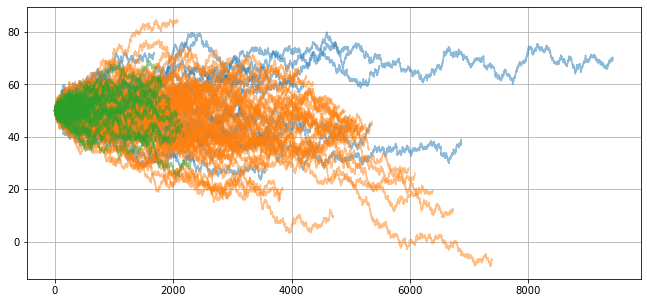

In [31]:
colors = ['tab:blue','tab:orange','tab:green']
for i in range(3):
    for k in range(len(norm_X_t_env[i])):
        fig = plot(norm_X_t_env[i][k],color=colors[i], alpha=0.5)
    grid(True)

In [32]:
norm_diff = []
for env in range(3):
    for i in range(len(norm_X_t_env[env])):
        for j in range(len(norm_X_t_env[env][i])-1):
            norm_diff.append(norm_X_t_env[env][i][j+1]-norm_X_t_env[env][i][j])

In [33]:
norm.fit(norm_diff) # expecting 0, 0.25

(-0.00029288222398599415, 0.25035960558049875)